In [1]:
import os, sys, argparse
import pandas as pd
import numpy as np

import pickle
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
parser = argparse.ArgumentParser(description='heatmap creator')
parser.add_argument('-o', '--output', type=str, default='-', action='store', help='target')
parser.add_argument('-d', '--data', type=str, default='alpha', choices=['alpha', 'amazon', 'epinions', 'otc'], help='data name')
parser.add_argument('-a', '--alg', type=str, default='bad', choices=['bn', 'feagle', 'fraudar', 'trust', 'rsd', 'bad'], help='alg name')

if bool(getattr(sys, 'ps1', sys.flags.interactive)):
    from tqdm import tqdm_notebook as tqdm
    print('interactive mode')
    parsed = parser.parse_args(['--data', 'alpha', '--alg', 'bn'])
else:
    from tqdm import tqdm
    print('script mode')
    parsed = parser.parse_args(sys.argv[1:])
    display=print

print(parsed)

interactive mode
Namespace(alg='bn', data='alpha', output='-')


In [61]:
# alg_list = ['bn', 'feagle', 'fraudar', 'trust', 'rsd', 'bad', 'rev2']
alg_list = ['rev2', 'bad', 'bn', 'trust', 'feagle', 'fraudar', 'rsd']
# data_list = ['alpha', 'amazon', 'epinions', 'otc']
data_list = ['otc', 'alpha', 'epinions', 'amazon']
q_range = np.array([0.005, 0.01, 0.03, 0.05, 0.1])
met_list = ['f1', 'prec', 'recl']

ccost_budget_pairs = [(8, 40), (6.5, 325), (6, 600), (6, 1000), (6, 1200)]

k_range = np.arange(10) / 10
n_range = list(range(0, 51, 5))
n_range[0] = 1

In [4]:
def plot_one_heatmap(fig, ax, plot_data, title=''):
    heat = ax.pcolor(plot_data)
    
    plot_data[1:, :][np.isnan(plot_data[1:, :])] = 1
    
    u_new = plot_data[1:, :].min()
    u_old = plot_data[0, :].mean()
    
    k_new, n_new = np.unravel_index(plot_data[1:, :].argmin(), plot_data[1:, :].shape)
    # because k_new starts from 1
    k_new += 1
    # print(k_range[k_new], n_range[n_new], plot_data[k_new, n_new])
    
    u_change = (u_new - u_old) / u_old
    t = '%s\n new %.3f, old %.3f, change %.3f\n k: %.1f, N:%d' %(title, u_new, u_old, u_change, k_range[k_new], n_range[n_new])
    ax.set_title(t)

    ax.set_xticks(range(len(n_range)))
    ax.set_xticklabels(n_range)

    ax.set_yticks(range(len(k_range)))
    ax.set_yticklabels(k_range)

    ax.set_xlabel('N: number of fair reviews')
    ax.set_ylabel('k: fraction of sockpuppets')

    return heat, [u_change, k_range[k_new], n_range[n_new]]

In [15]:
def create_heatmaps(alg, data):
    eval_path = '../res/%s/budget-eval-%s.pkl' %(alg, data)
    print(eval_path)
    if not os.path.exists(eval_path):
        print(alg, data, 'not exists')
        return None, {qq: {met: None for met in met_list} for qq in q_range}
    
    with open(eval_path, 'rb') as fp:
        metrics_dict = pickle.load(fp)
    
    figs = []
    q_dict = {}
    ret = {}
    for ccost, budget in ccost_budget_pairs:
        print(ccost, budget)
        q_dict[(ccost, budget)] = {}
        for q in range(5):
            heat_dict = {'f1': np.full([10, 11], np.inf), 'prec': np.full([10, 11], np.inf), 'recl': np.full([10, 11], np.inf)}

            for k, n in itertools.product(range(10), range(11)):
                m = [metrics_dict[(ccost, budget)][(k, n_range[n], ind)]['f1'][q_range[q]] for ind in range(50) if metrics_dict[(ccost, budget)][(k, n_range[n], ind)] is not None]
                if len(m) > 11:
                    heat_dict['f1'][k, n] = np.mean(m)
                else:
                    heat_dict['f1'][k, n] = np.nan

                m = [metrics_dict[(ccost, budget)][(k, n_range[n], ind)]['prec'][q_range[q]] for ind in range(50) if metrics_dict[(ccost, budget)][(k, n_range[n], ind)] is not None]
                if len(m) > 11:
                    heat_dict['prec'][k, n] = np.mean(m)
                else:
                    heat_dict['prec'][k, n] = np.nan

                m = [metrics_dict[(ccost, budget)][(k, n_range[n], ind)]['recl'][q_range[q]] for ind in range(50) if metrics_dict[(ccost, budget)][(k, n_range[n], ind)] is not None]
                if len(m) > 11:
                    heat_dict['recl'][k, n] = np.mean(m)
                else:
                    heat_dict['recl'][k, n] = np.nan
            q_dict[(ccost, budget)][q] = heat_dict
    
    for ccost, budget in ccost_budget_pairs:
        fig, axes = plt.subplots(3, 5, figsize=(16, 9))
        ret[(ccost, budget)] = {}
        for q in range(5):
            ret[(ccost, budget)][q_range[q]] = {}
            h1,r1 = plot_one_heatmap(fig, axes[0, q], q_dict[(ccost, budget)][q]['f1'], title='f1 score @ q %.1f%%' %(q_range[q]*100))
            h2,r2 = plot_one_heatmap(fig, axes[1, q], q_dict[(ccost, budget)][q]['prec'], title='precision @ q %.1f%%' %(q_range[q]*100))
            h3,r3 = plot_one_heatmap(fig, axes[2, q], q_dict[(ccost, budget)][q]['recl'], title='recall @ q %.1f%%' %(q_range[q]*100))
            ret[(ccost, budget)][q_range[q]]['f1'] = r1
            ret[(ccost, budget)][q_range[q]]['prec'] = r2
            ret[(ccost, budget)][q_range[q]]['recl'] = r3
        fig.colorbar(h1)
        fig.tight_layout()
        figs.append(fig)
    
    return figs, ret

../res/feagle/budget-eval-amazon.pkl
6 600
6.5 325
7 70
8 40
6 1200
6 1000


,0.005,0.01,0.03,0.05,0.1
f1,"[-0.9459803639537985, 0.8, 1]","[-0.9395570510451826, 0.8, 1]","[-0.8972254423075432, 0.8, 1]","[-0.8320786319861838, 0.8, 1]","[-0.6809828963753815, 0.3, 1]"
prec,"[-0.09186975761178248, 0.2, 1]","[-0.11003236245954685, 0.2, 1]","[-0.1482804434473895, 0.2, 1]","[-0.13899009352951652, 0.2, 1]","[0.0009547290840088351, 0.1, 10]"
recl,"[-0.9699290513367409, 0.8, 1]","[-0.9664364405724547, 0.8, 1]","[-0.9429164579736252, 0.8, 1]","[-0.9061405771708272, 0.8, 1]","[-0.8246782589780904, 0.3, 1]"


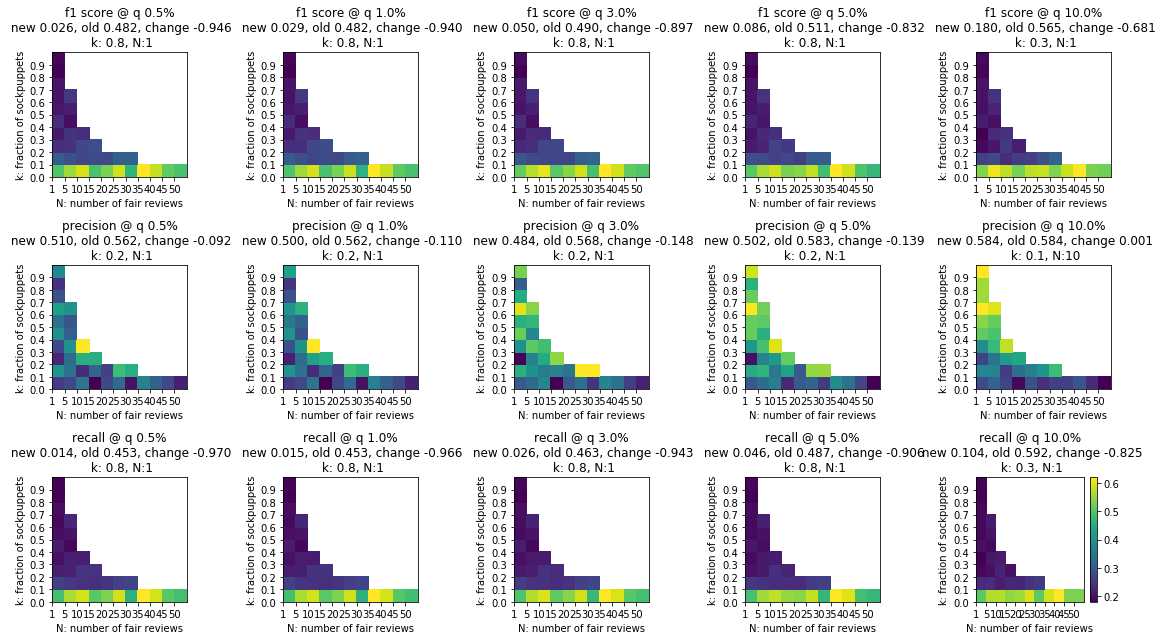

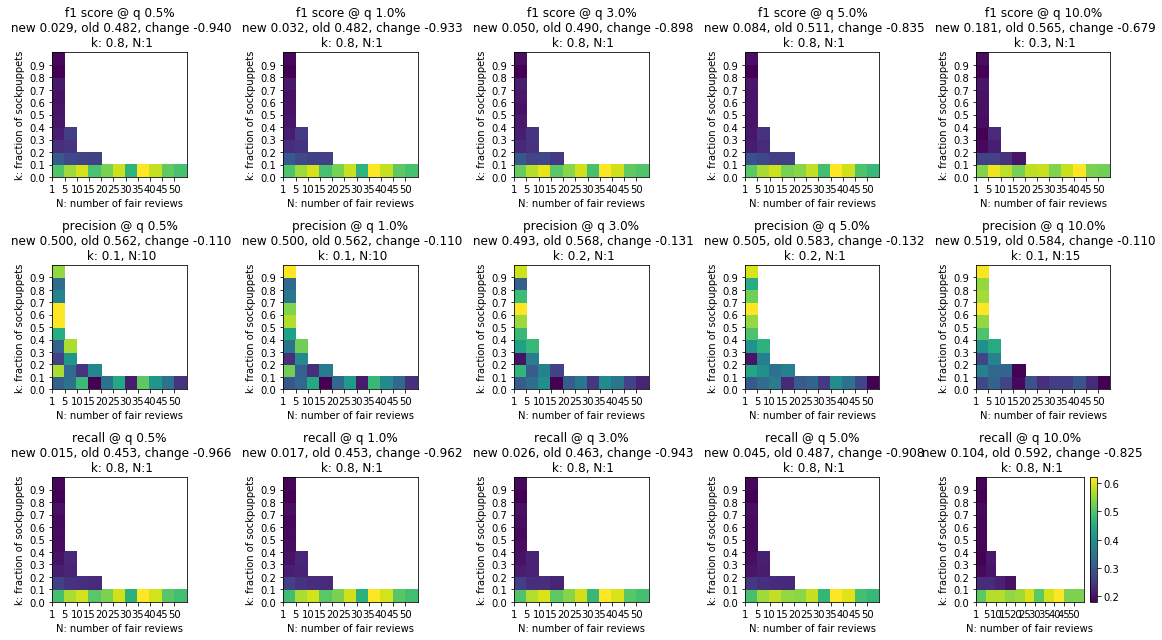

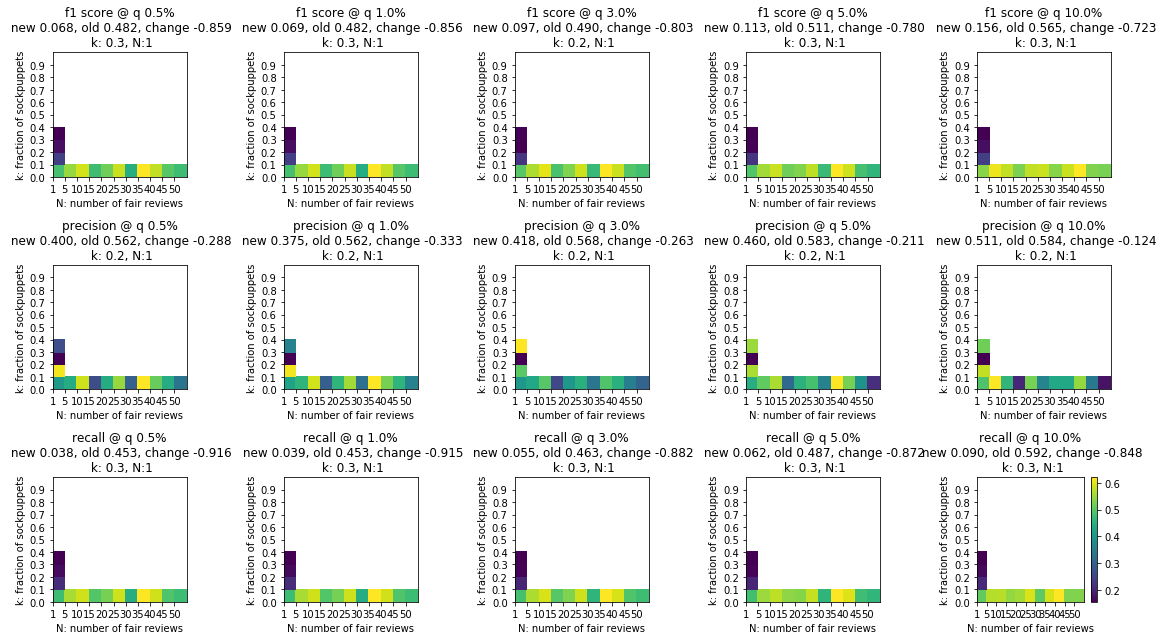

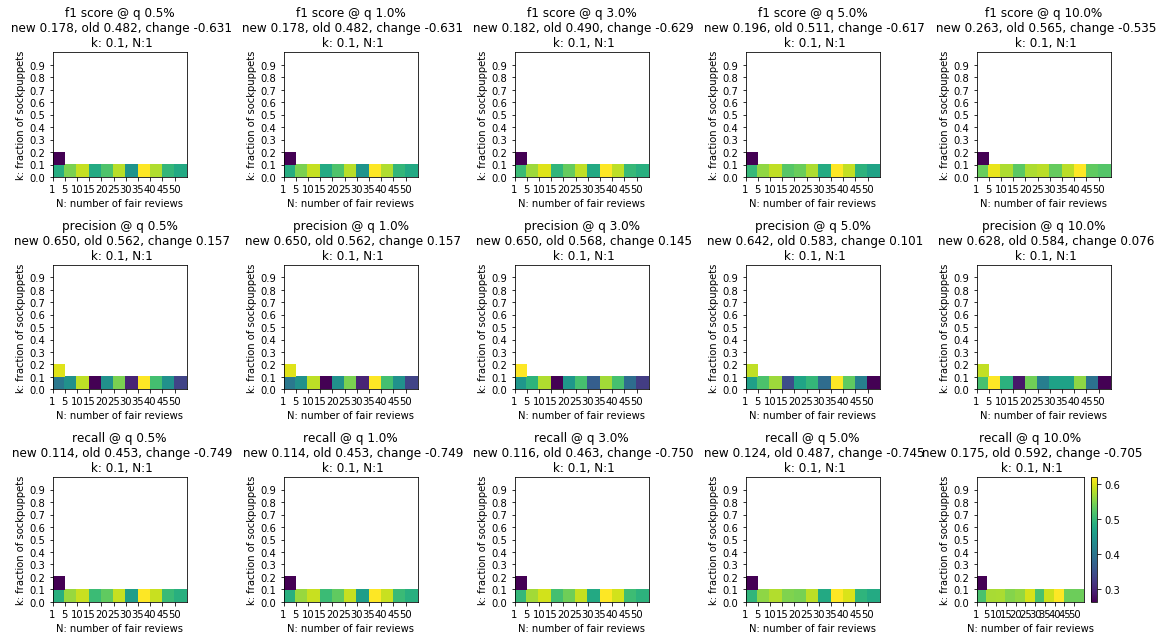

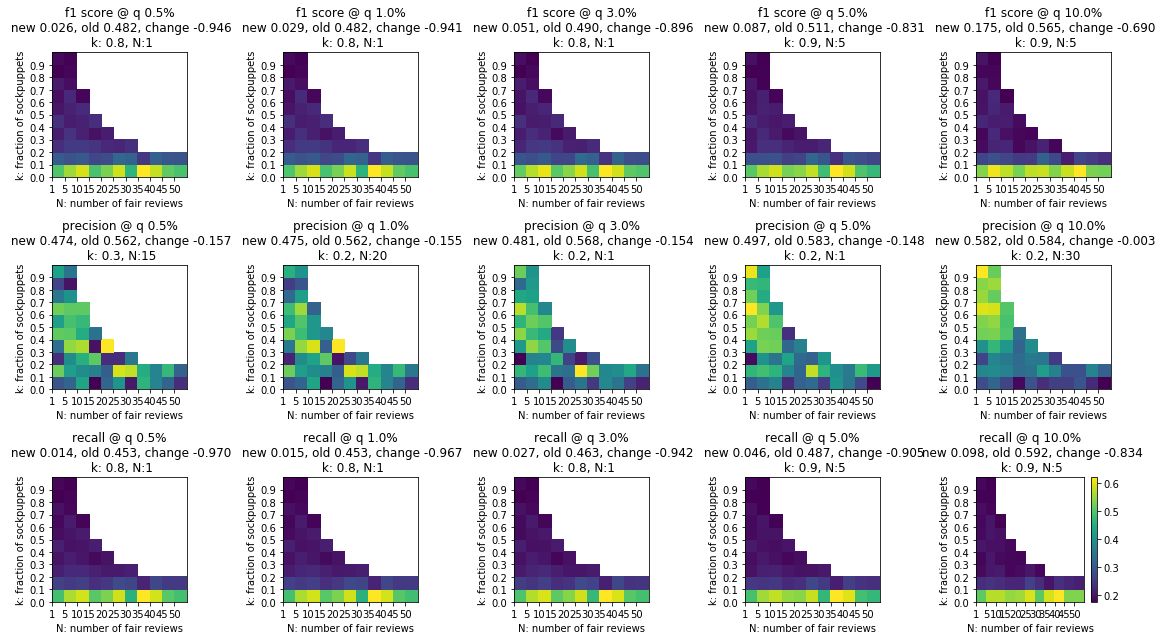

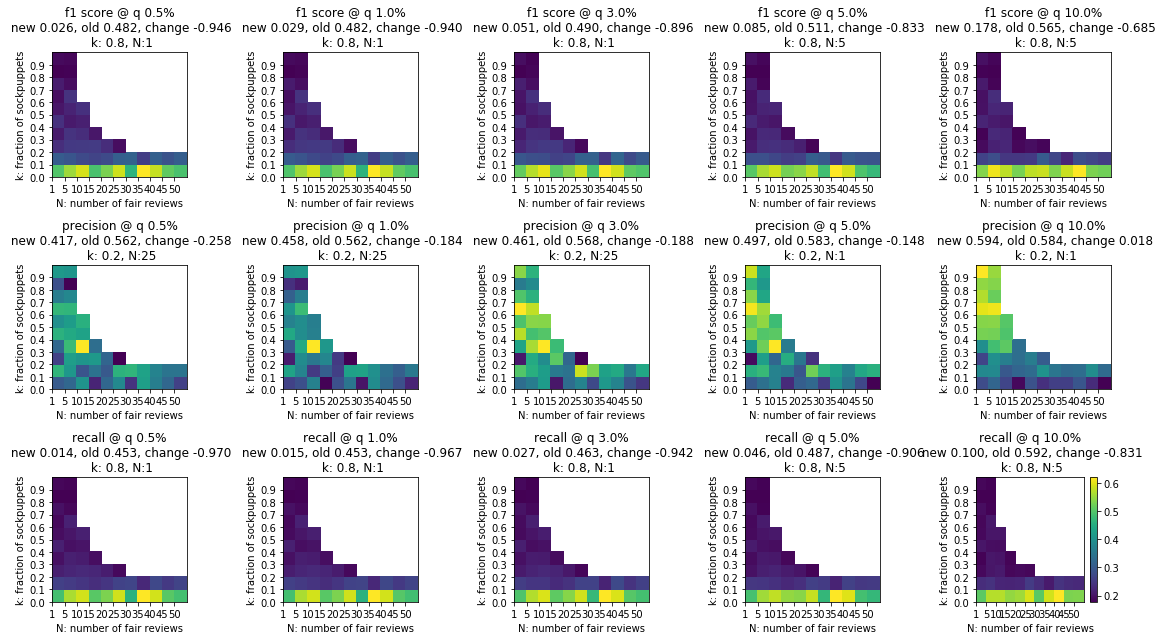

In [16]:
# fig, ret = create_heatmaps(alg='rsd', data='amazon')
# display(pd.DataFrame(ret))
fig, ret = create_heatmaps(alg='feagle', data='amazon')
display(pd.DataFrame(ret[(6, 600)]))

In [30]:
reports = {met: {q: {alg: {data: {} for data in data_list} for alg in alg_list} for q in q_range} for met in met_list}

reports_line = {alg: {data: {} for data in data_list} for alg in alg_list}

for alg in alg_list:
    for data in data_list:
        figs, ret = create_heatmaps(alg, data)
        if figs != None:
            for i in range(len(figs)):
                fig = figs[i]
                fig.savefig('../res/budget/%s-%s-%d.pdf' %(alg, data, i))
        plt.close('all')
        reports_line[alg][data] = ret
        # pd.DataFrame(ret).to_csv('../res/heatmaps/%s-%s.csv' %(alg, data))
#         for q in q_range:
#             for met in met_list:
#                 if ret[q][met] != None:
#                     reports[met][q][alg][data] = '%.3f \n k=%.2f \n n=%d' %tuple(ret[q][met])
#                 else:
#                     reports[met][q][alg][data] = ''

rev2 otc
../res/rev2/budget-eval-otc.pkl
7 70
8 40
6.5 325
6 600
6 1200
6 1000
rev2 alpha
../res/rev2/budget-eval-alpha.pkl
7 70
8 40
6.5 325
6 600
6 1200
6 1000
rev2 epinions
../res/rev2/budget-eval-epinions.pkl
rev2 epinions not exists
rev2 amazon
../res/rev2/budget-eval-amazon.pkl
7 70
8 40
6.5 325
6 600
6 1200
6 1000
bad otc
../res/bad/budget-eval-otc.pkl
7 70
8 40
6.5 325
6 600
6 1200
6 1000
bad alpha
../res/bad/budget-eval-alpha.pkl
7 70
8 40
6.5 325
6 600
6 1200
6 1000
bad epinions
../res/bad/budget-eval-epinions.pkl
7 70
8 40
6.5 325
6 600
6 1200
6 1000
bad amazon
../res/bad/budget-eval-amazon.pkl
7 70
8 40
6.5 325
6 600
6 1200
6 1000
bn otc
../res/bn/budget-eval-otc.pkl
7 70
8 40
6.5 325
6 600
6 1200
6 1000
bn alpha
../res/bn/budget-eval-alpha.pkl
7 70
8 40
6.5 325
6 600
6 1200
6 1000
bn epinions
../res/bn/budget-eval-epinions.pkl
7 70
8 40
6.5 325
6 600
6 1200
6 1000
bn amazon
../res/bn/budget-eval-amazon.pkl
7 70
8 40
6.5 325
6 600
6 1200
6 1000
trust otc
../res/trust/budget

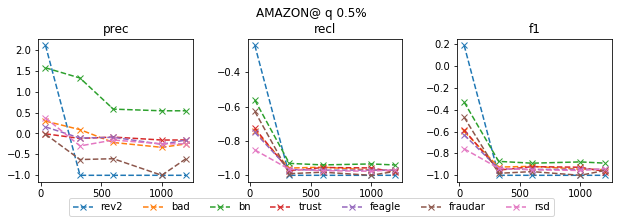

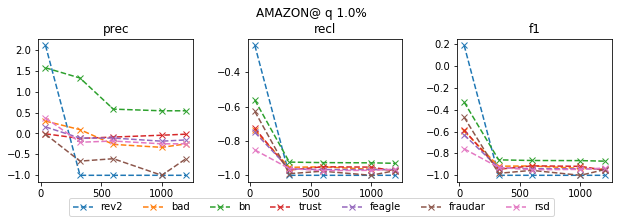

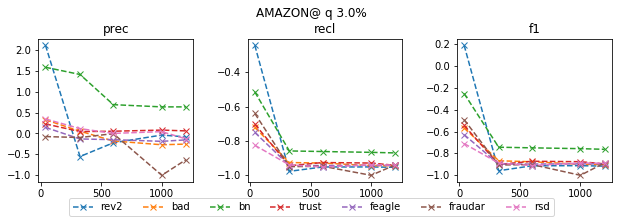

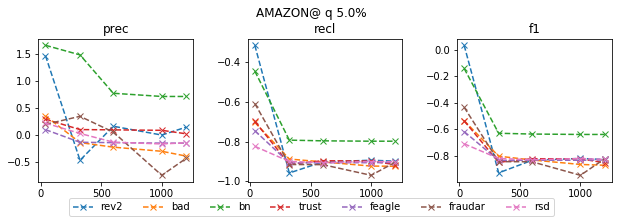

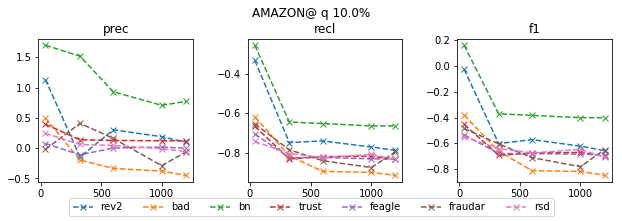

In [81]:
data = 'otc'
q = 2

def plot_line(data, q):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))

    lines = []
    met = 'prec'
    axes[0].set_title(met)
    for alg in alg_list:
        b_list = [b for c, b in ccost_budget_pairs]
        change_list = [reports_line[alg][data][(c, b)][q_range[q]][met][0] for c, b in ccost_budget_pairs]
        l, = axes[0].plot(b_list, change_list, ls='--', marker='x')

    met = 'recl'
    axes[1].set_title(met)
    for alg in alg_list:
        b_list = [b for c, b in ccost_budget_pairs]
        change_list = [reports_line[alg][data][(c, b)][q_range[q]][met][0] for c, b in ccost_budget_pairs]
        l, = axes[1].plot(b_list, change_list, ls='--', marker='x')

    met = 'f1'
    axes[2].set_title(met)
    for alg in alg_list:
        b_list = [b for c, b in ccost_budget_pairs]
        change_list = [reports_line[alg][data][(c, b)][q_range[q]][met][0] for c, b in ccost_budget_pairs]
        l, = axes[2].plot(b_list, change_list, ls='--', marker='x')
        lines.append(l)

    fig.suptitle(data.upper() + '@ q %.1f%%' %(q_range[q]*100))
    fig.legend(lines, alg_list, loc='lower center', ncol=len(alg_list))
    fig.tight_layout(pad=2)
    
    return fig

for data in ['amazon']:
    for q in range(len(q_range)):
        fig = plot_line(data, q)
        fig.savefig('../figures/budget/%s-%d.pdf' %(data, q))

In [ ]:
# for met in met_list:
#     for q in q_range:
#         print(met, q)
#         df = pd.DataFrame(reports[met][q]).loc[data_list]
#         df.to_csv('../res/budget/%s-%.3f.csv' %(met, q))